In [4]:
import helpers

In [15]:
import importlib
importlib.reload(helpers)

<module 'helpers' from 'C:\\Users\\taras\\Documents\\Аспирантура МГУ\\Техносфера mail.ru\\IR\\Итоговый конкурс\\helpers.py'>

In [2]:
from tqdm.notebook import tqdm
import numpy as np
from collections import defaultdict

In [3]:
from multiprocessing.dummy import Pool, Lock, Queue

In [3]:
import pandas as pd
import json

### Sphinx API

In [23]:
import sphinxapi
import sys

In [26]:
q = ''
mode = sphinxapi.SPH_MATCH_ANY
host = '127.0.0.1'
port = 9312
index = 'docs1'
limit = 0

# do query
cl = sphinxapi.SphinxClient()
cl.SetServer(host, port)
cl.SetMatchMode(mode)
cl.SetLimits(limit, max(limit, 1))
#cl.SetFieldWeights({'title': 2, 'body': 3});
cl.SetSelect('id, title, packedfactors()')
#cl.SetRankingMode(SPH_RANK_EXPR, rankexpr="bm25")
cl.SetSortMode(sphinxapi.SPH_SORT_RELEVANCE)

In [27]:
res = cl.Query('аэропорт', index)
res

{'error': '',
 'warning': 'packedfactors() and bm25f() requires using an expression ranker',
 'status': 3,
 'fields': ['title', 'body'],
 'attrs': [['title', 7], ['packedfactors()', 1001]],
 'matches': [{'id': 11,
   'weight': 21768,
   'attrs': {'title': 'аэропорт храброво новости', 'packedfactors()': ''}}],
 'total': 17,
 'total_found': 17,
 'time': '0.036',
 'words': [{'word': 'аэропорт', 'docs': 17, 'hits': 710}]}

### SphinxQL

option:  
field_weights=(title=2, body=3)    
ranker=bm25  

quorum matching, "pick any 3 keywords out of this entire set"/3  
https://www.rupython.com/sphinx-search-engine-api-python-73748.html  
https://sphinxsearch.com/docs/sphinx3.html#running-queries-via-mysql-shell

bm25f(1.2, 0.75) = bm25a  
BM25F(k1,b,{field_weights_list})  
http://sphinxsearch.com/blog/2013/03/22/new-bm25-functions-and-idf-operators-in-custom-rankers/

SPH_RANK_SPH04 = sum((4*lcs+2*(min_hit_pos==1)+exact_hit)*user_weight)*1000+bm25  
https://sphinxsearch.com/docs/manual-2.3.2.html#document-factors

Quick summary of the ranking factors  
http://sphinxsearch.com/docs/current/ranking-factors.html  
bm25a, bm25f

In [8]:
with helpers.get_sphinx_conn() as sphinx_conn, sphinx_conn.cursor() as cursor:
    match = '\'"2016 действует ли зао рождественская мануфактура"/1\''
    query = 'SELECT id, title, factors(), weight() FROM docs WHERE MATCH(' + match + ') \
             LIMIT 0, 1 OPTION ranker=expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\'),\
             field_weights=(title=1, body=1)'
    cursor.execute(query)
    rows = cursor.fetchall()
    print(len(list(rows)))
    print(*rows, sep='\n')

1
(80518, 'рождественская мануфактура зао рождественская мануфактура тверь производственное предприятие на ул спартака 47а на справке ру телефоны карта фото отзывы и оценки клиентов', '{"bm15":9571, "bm25a":11.018845, "field_mask":3, "doc_word_count":4, "fields":[{"field":0, "lcs":3, "hit_count":5, "word_count":3, "tf_idf":18.551353, "min_idf":3.094606, "max_idf":4.617383, "sum_idf":10.839363, "min_hit_pos":1, "min_best_span_pos":3, "exact_hit":0, "exact_field_hit":0, "full_field_hit":0, "max_window_hits":1, "min_gaps":0, "exact_order":0, "lccs":3, "wlccs":10.839363, "atc":4.878920, "sum_idf_boost":3.000000, "is_noun_hits":5, "is_latin_hits":0, "is_number_hits":0, "has_digit_hits":0, "phrase_decay10":0.525674, "phrase_decay30":0.475400}, {"field":1, "lcs":3, "hit_count":19, "word_count":4, "tf_idf":68.944572, "min_idf":0.993917, "max_idf":4.617383, "sum_idf":11.833281, "min_hit_pos":6, "min_best_span_pos":14, "exact_hit":0, "exact_field_hit":0, "full_field_hit":0, "max_window_hits":1, 

In [9]:
limit = 1
ranker = 'expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\')'
fields = ['id', 'title', 'weight()']
index = 'docs'
query = '2016 действует ли зао рождественская мануфактура'
rows = helpers.select_from_sphinx_wrapper(query, index, fields, limit, ranker)
print(*rows, sep='\n')

(80518, 'рождественская мануфактура зао рождественская мануфактура тверь производственное предприятие на ул спартака 47а на справке ру телефоны карта фото отзывы и оценки клиентов', 35571.0)


In [10]:
limit = 1
ranker = 'sph04'
fields = ['id', 'title', 'weight()']
index = 'docs'
query = '2016 действует ли зао рождественская мануфактура'
rows = helpers.select_from_sphinx_wrapper(query, index, fields, limit, ranker)
print(*rows, sep='\n')

(80518, 'рождественская мануфактура зао рождественская мануфактура тверь производственное предприятие на ул спартака 47а на справке ру телефоны карта фото отзывы и оценки клиентов', 269571.3)


**call keywords**

tokenized, normalized, docs, hits, plain_idf, global_idf, has_global_idf, is_latin, in_noun, is_number, has_digit

In [195]:
query = '1 месяц после операции на кишечнику диета что можно добавить'
index = 'docs1'
with helpers.get_sphinx_conn() as sphinx_conn, sphinx_conn.cursor() as cursor:
    query = f"call keywords('{query}', '{index}', 1)"
    cursor.execute(query)
    rows = cursor.fetchall()
    print(*rows, sep='\n')

('1', '1', '1', '91', '2613', '0.094311', '0.000000', '0', '0', '0', '1', '1')
('2', 'месяц', 'месяц', '48', '329', '0.733969', '0.000000', '0', '0', '1', '0', '0')
('3', 'после', 'посол', '72', '1014', '0.328504', '0.000000', '0', '0', '1', '0', '0')
('4', 'операции', 'операция', '31', '94', '1.171183', '0.000000', '0', '0', '1', '0', '0')
('5', 'на', 'на', '100', '13812', '0.000000', '0.000000', '0', '0', '0', '0', '0')
('6', 'кишечнику', 'кишечник', '2', '4', '3.912023', '0.000000', '0', '0', '1', '0', '0')
('7', 'диета', 'диета', '8', '14', '2.525729', '0.000000', '0', '0', '1', '0', '0')
('8', 'что', 'что', '90', '8002', '0.105361', '0.000000', '0', '0', '0', '0', '0')
('9', 'можно', 'можно', '75', '1344', '0.287682', '0.000000', '0', '0', '0', '0', '0')
('10', 'добавить', 'добавить', '59', '758', '0.527633', '0.000000', '0', '0', '0', '0', '0')


**call snippets**

In [16]:
body = 'очень воспитанный мальчик упал в люк и закрыл его за собой добавить в избранное сделать стартовой разделы сайта главная страница команда сайта музыка хит парад тексты песен переводы песен flash игры стихи юмор анекдоты и стишки смешные картинки истории счетчики событий гостевая книга поддержка сайта вам понравился сайт sentido ru есть несколько способов помочь его развитию 1 отправить собственный перевод на сайт 2 стать модератором сайта получив права добавлять тексты стихи переводы на сайт для этого нужно отправить свои контакты администратору сайта 3 стать спонсором или партнером сайта подробности можно узнать здесь лучшие страницы первый раз на сайте рекомендуем посетить его лучшие страницы 1 уловить смысл песен fallen kiss the rain shape of my heart confessa my immortal je t aime stay it will rain 2 вспомнить прекрасные строки я могу тебя вечно ждать пролистнуть в листве березовой осиновой взглянуть на календарь произнося двадцать первое ночь понедельник 3 напеть давно забытый мотив бесконечности послушать мелодию о лютой ненависти и святой любви погрустить вдвоем вместе с летним дождем виджеты для вашего удобства мы создали виджеты быстрого доступа к сайту через главную страницу яндекса имеется возможность установить три виджета быстрого доступа как по отдельности так и все вместе 1 к переводам лучших иностранных песен 2 к текстам песен отечественных и иностранных исполнителей 3 к лучшим стихам и рассказам о любви классиков жанра и современных авторов для установки перейдите на страницу виджетов популярные стихи сайта двадцатка самых популярных стихов на сайте sentido ru 1 рождественский роберт я в глазах твоих утону можно 2 пушкин александр письмо онегина татьяне отрывок из романа евгений онегин 3 пушкин александр письмо татьяны онегину отрывок из романа евгений онегин 4 рождественский роберт будь пожалуйста послабее 5 асадов эдуард я могу тебя очень ждать 6 рождественский роберт мы совпали с тобой 7 пушкин александр я помню чудное мгновенье 8 асеев николай я не могу без тебя жить 9 есенин сергей заметался пожар голубой 10 есенин сергей ты меня не любишь не жалеешь 11 цветаева марина мне нравится что вы больны не мной 12 визбор юрий мне твердят что скоро ты любовь найдешь 13 асадов эдуард ты далеко сегодня от меня 14 высоцкая ольга любовь она бывает разной 15 ахматова анна двадцать первое ночь понедельник 16 северянин игорь встречаются чтоб расставаться 17 пастернак борис любить иных тяжелый крест 18 друнина юлия ты рядом 19 дементьев андрей ни о чем не жалейте 20 рождественский роберт приходить к тебе буква выбрать букву а б в г д е ж з и к л м н о п р с т у ф х ц ч ш щ э я автор произведение a б в г д е ж з и к л м н о п р с т у ф х ц ч ш щ э ю я вернуться к списку произведений автора асадов эдуард моя любовь ну каким ты владеешь секретом чем взяла меня и когда но с тобой я всегда всегда днем и ночью зимой и летом площадями ль иду большими иль за шумным сижу столом стоит мне шепнуть твое имя и уже мы с тобой вдвоем когда радуюсь или грущу я и когда обиды терплю и в веселье тебя люблю я и в несчастье тебя люблю даже если крепчайше сплю все равно я тебя люблю говорят что дней круговерть настоящих чувств не тревожит говорят будто только смерть навсегда погасить их может я не знаю последнего дня но без громких скажу речей смерть конечно сильней меня но любви моей не сильней и когда мой звонок пробъет и окончу я путь земной знай любовь моя не уйдет а останется тут с тобой подойдет без жалоб и слез и незримо для глаз чужих словно верный и добрый пес на колени положит нос и свернется у ног твоих лучшие поэты асадов эдуард ахматова анна блок александр есенин сергей набоков владимир пушкин александр цветаева марина избранные стихи я могу тебя очень ждать мне большего не надо я в глазах твоих утону можно ты рядом и все прекрасно я не могу без тебя жить ты далеко сегодня от меня ошибка двадцать первое ночь понедельник весенняя сказка дождя рассказ мы совпали с тобой я отпускаю тебя отпускаю любовь она бывает разной любим мы друг друга или нет в листве березовой осиновой обидная любовь встречаются чтоб расставаться письмо любимой твое лицо мне так знакомо есть в близости людей заветная черта ты меня не любишь не жалеешь ночь приходить к тебе любви начало было летом мне нравится что вы больны не мной для школьного возраста любовь покоряет обманно десятая заповедь ты хочешь сделать мир счастливым ты письмо мое милый не комкай ее душа как свет необычайный вечером поэма о первой нежности любить иных тяжелый крест рекомендуем установить виджет быстрого доступа ко всем стихам и рассказам общение все отзывы пожелания предложения пишите в гостевую книгу или шлите по e mail tosha22 yandex ru популярные переводы сайта двадцатка самых популярных переводов на сайте sentido ru 1 okean elzi океан эльзы на небі 2 okean elzi океан эльзы без бою 3 okean elzi океан эльзы обійми 4 sia chandelier 5 adele hello 6 imany don t be so shy 7 dzidzo дзідзьо ft vovazilvova павук 8 sting shape of my heart 9 olga kormuhina ольга кормухина путь 10 lara fabian je t aime 11 okean elzi океан эльзы я так хочу до тебе 12 bumboks бумбокс наодинці 13 blank and jones ft delerium fallen 14 sarah brightman hijo de la luna 15 bumboks бумбокс квіти в волоссі 16 bumboks бумбокс дитина 17 rihanna diamonds 18 okean elzi океан эльзы rendez vous 19 skillet awake and alive 20 david usher black black heart популярные тексты сайта двадцатка самых популярных текстов на сайте sentido ru 1 алла пугачева нас бьют мы летаем 2 ани лорак забирай 3 жуки батарейка 4 ирина дубцова люби меня долго 5 чиж и со на поле танки грохотали 6 нюша ангел 7 полина гагарина колыбельная 8 евро колян 9 градусы голая 10 ани лорак снится сон 11 виагра и мот кислород 12 нюша танцы на стеклах 13 елка около тебя 14 нервы слишком влюблен 15 machete токио нежность 16 сектор газа 30 лет 17 елка все зависит от нас самих 18 елка на большом воздушном шаре 19 тина кароль україна це ти 20 дискотека авария недетское время обновления сайта добавлены переводы песен 1 meg myers make a shadow 2 meg myers go 3 meg myers sorry 4 guano apes tribute 5 guano apes when the ships arrive 6 amy lee ft dave eggar lockdown 7 feeling numb drama 8 meg myers i die 9 tamoto beware 10 guano apes fanman добавлены тексты песен 1 серебро chocolate 2 дмитрий колдун поцелуй меня 3 баста и полина гагарина голос 4 леонид агутин птица черная 5 леонид агутин севастополь 6 леонид агутин отец рядом с тобой 7 леонид агутин мир зеленого цвета 8 нюша целуй 9 ирина дубцова бойфренд 10 мот маврикий мы всегда рады видеть вас на нашем сайте заходите почаще ведь здесь всегда уютно приятно и интересно полет нормальный идея и оформление сайта седельников антон aka tosha 1783 2015 правила использования сайта реклама на сайте'

In [66]:
def get_snippet(sphinx_conn, text, index, query, limit=1024):
    query = '|'.join(query.split())
    query = helpers.cut_query(query)
    with sphinx_conn.cursor() as cursor:
        query = f"call snippets('{text}', '{index}', '{query}', '' as before_match, \
                '' as after_match, ' ' as chunk_separator, {limit} as limit, 1 as allow_empty)"
        cursor.execute(query)
        row = cursor.fetchone()
    return row[0].strip()

In [68]:
match = 'в и календарь'
with helpers.get_sphinx_conn() as sphinx_conn:
    print(get_snippet(sphinx_conn, body, 'docs', match, limit=1024))

мальчик упал в люк и закрыл его за собой добавить в избранное сделать  flash игры стихи юмор анекдоты и стишки смешные картинки истории счетчики  вечно ждать пролистнуть в листве березовой осиновой взглянуть на календарь произнося двадцать  послушать мелодию о лютой ненависти и святой любви погрустить вдвоем вместе  2 к текстам песен отечественных и иностранных исполнителей 3 к лучшим  стихам и рассказам о любви классиков жанра  и современных авторов для установки перейдите   я всегда всегда днем и ночью зимой и летом площадями ль иду  когда обиды терплю и в веселье тебя люблю я и в несчастье тебя люблю даже  с тобой подойдет без жалоб и слез и незримо для глаз чужих  словно верный и добрый пес на колени положит  быстрого доступа ко всем стихам и рассказам общение все отзывы пожелания  колдун поцелуй меня 3 баста и полина гагарина голос 4 леонид  всегда уютно приятно и интересно полет нормальный идея и оформление сайта седельников


### Нормализация queries

In [109]:
queries_df = pd.read_csv('corrected_queries.tsv', sep='\t')

In [135]:
titles = queries_df.corrected_query.values

In [136]:
norm_titles = []
index = 'docs'
with helpers.get_sphinx_conn() as conn,  conn.cursor() as cursor:
    for text in tqdm(titles, total=len(titles)):
        norm_text = norm_doc(cursor, text, index)
        norm_titles.append(norm_text)

In [141]:
queries_df['query_norm'] = norm_titles

In [142]:
queries_df.to_csv('corrected_queries.tsv', index=False, sep='\t')

### Построение признаков

In [8]:
queries_df = pd.read_csv('corrected_queries.tsv', sep='\t')

In [9]:
len(queries_df)

6311

In [10]:
def get_sphinx_features_list(row):
    sphinx_features = []
    json_str = row[2].replace('-nan', '-100')
    factor_dict = json.loads(json_str)
    for key, value in factor_dict.items():
        if key == 'fields':
            for field_dict in value:
                field_features = list(field_dict)[1:]
                sphinx_features_field = [field_dict[k] for k in field_features]
                sphinx_features.extend(sphinx_features_field)
        elif key == 'query':
            sphinx_features_query = [v for v in value.values()]
            sphinx_features.extend(sphinx_features_query)
        elif key == 'words':
            continue
        else:
            sphinx_features.append(value)
    return sphinx_features

In [1020]:
def get_sphinx_features_dict(row):
    sphinx_features = defaultdict(float)
    json_str = row[2].replace('-nan', '-100')
    factor_dict = json.loads(json_str)
    for key, value in factor_dict.items():
        if key == 'fields':
            for field_dict in value:
                prefix = str(field_dict['field']) + '_'
                field_features = list(field_dict)[1:]
                sphinx_features_field = {prefix + k: field_dict[k] for k in field_features}
                sphinx_features.update(sphinx_features_field)
        elif key == 'query':
            prefix = 'query_'
            sphinx_features_query = {prefix + k: v for k, v in value.items()}
            sphinx_features.update(sphinx_features_query)
        elif key == 'words':
            sphinx_features['words'] = value
        else:
            prefix = 'document_'
            sphinx_features[prefix + key] = value
    return sphinx_features

In [1021]:
limit = 1
ranker = 'expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\')'
fields = ['id', 'title', 'factors()', 'weight()']
index = 'docs'
query = '2016 действует ли зао рождественская мануфактура'
rows = helpers.select_from_sphinx_wrapper(query, index, fields, limit, ranker)

In [1022]:
sphinx_features = get_sphinx_features_dict(rows[0])
f_columns = list(sphinx_features.keys())

In [424]:
len(f_columns)

64

In [1023]:
sphinx_features['words']

[{'tf': 1, 'idf': 0.993917},
 {'tf': 0, 'idf': 0.987086},
 {'tf': 0, 'idf': 0.542458},
 {'tf': 3, 'idf': 3.127373},
 {'tf': 10, 'idf': 3.094606},
 {'tf': 10, 'idf': 4.617383}]

In [145]:
limit = 200
ranker = 'expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\')'
fields = ['id', 'title', 'factors()', 'weight()']
index = 'docs'
qids = []
dids = []
titles = []
sph04_list = []
dq_features = {c: [] for c in f_columns}
with get_sphinx_conn() as sphinx_conn:
    for i, row in tqdm(queries_df.iterrows(), total=len(queries_df)):
        query = row.corrected_query
        qid = row.id
        docs = helpers.select_from_sphinx(sphinx_conn, query, index, fields, limit, ranker)

        for doc in docs:
            qids.append(qid)
            dids.append(doc[0])
            titles.append(doc[1])
            sph04_list.append(doc[3])
            sphinx_features = get_sphinx_features_dict(doc)
            for c in f_columns:
                dq_features[c].append(sphinx_features[c])

In [ ]:
data_dict = {'query_id': qids, 'doc_id': dids, 'doc_title': titles, 'sph04': sph04_list}
data_dict.update(dq_features)
data_df = pd.DataFrame(data = data_dict)

helpers.save_obj(data_df, '200_data_df')
data_df.to_csv('200_data_df.csv', index=False, sep='\t')

### Create dataset based on 'train.marks.tsv' for LTR

In [14]:
marks_df = pd.read_csv('train.marks.tsv', sep='\t', header=None)
marks_df.rename(columns={0: "QueryID", 1: "DocID", 2: "Mark"}, inplace=True)

In [39]:
def select_docs_by_id_list(query, ids, index, fields, limit, ranker):
    with helpers.get_sphinx_conn() as sphinx_conn, sphinx_conn.cursor() as cursor:
        match = '\'"' + query + '"/1\''
        query = 'SELECT ' + ', '.join(fields) + ' FROM ' + index + ' WHERE MATCH(' + match + ') \
                 and id in (' + ','.join(ids) + ') LIMIT 0, ' + str(limit) + \
                ' OPTION ranker=' + ranker
        cursor.execute(query)
        rows = cursor.fetchall()
    return rows

In [430]:
qids_to_select = np.unique(marks_df['QueryID'], return_counts=False)

In [431]:
index = 'docs'
ranker = 'expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\')'
fields = ['id', 'title', 'factors()', 'weight()']

qids_mark = []
dids_mark = []
titles_mark = []
sph04_list_mark = []
dq_features_mark = {c: [] for c in f_columns}

for qid in tqdm(qids_to_select, total=len(qids_to_select)):
    ids = list(map(str, marks_df[marks_df.QueryID == qid].DocID.values))
    limit = len(ids)
    query = queries_df[queries_df.id == qid].corrected_query.values[0]
    docs = select_docs_by_id_list(query, ids, index, fields, limit, ranker)
    
    for doc in docs:
        qids_mark.append(qid)
        dids_mark.append(doc[0])
        titles_mark.append(doc[1])
        sph04_list_mark.append(doc[3])
        sphinx_features = get_sphinx_features_dict(doc)
        for c in f_columns:
            dq_features_mark[c].append(sphinx_features[c])

**Не получены данные по документам:**

In [5]:
queries_df = pd.read_csv('corrected_queries.tsv', sep='\t')

In [5]:
train_sphinx_df = pd.read_csv('train_sphinx_df.csv', sep='\t')
test_sphinx_df = pd.read_csv('test_sphinx_df.csv', sep='\t')

In [6]:
train_sphinx_df

,query_id,doc_id,sph04,document_bm15,document_bm25a,document_field_mask,document_doc_word_count,0_lcs,0_hit_count,0_word_count,...,query_max_lcs,query_word_count,query_is_noun_words,query_is_latin_words,query_is_number_words,query_has_digit_words,query_max_idf,query_min_idf,query_sum_idf,doc_url
0,2,19489,6746.0,2746,1.620457,2,3,0.0,0.0,0.0,...,12,6,4,0,1,1,4.617383,0.542458,13.362823,www.historyru.com/doc/persons/xr/mem/book1a.html
1,2,30946,9405.0,5405,4.085787,2,4,0.0,0.0,0.0,...,12,6,4,0,1,1,4.617383,0.542458,13.362823,panoramakz.com/archiv/2002/46.htm
2,2,33190,8553.0,4553,4.028360,2,4,0.0,0.0,0.0,...,12,6,4,0,1,1,4.617383,0.542458,13.362823,cameroon.polpred.com/news/?detail=82&ns=2&page...
3,2,37143,8188.0,4188,4.095489,2,4,0.0,0.0,0.0,...,12,6,4,0,1,1,4.617383,0.542458,13.362823,www.rwandaforeigntrade.polpred.com/?ns=1
4,2,37469,10277.0,6277,4.572857,2,5,0.0,0.0,0.0,...,12,6,4,0,1,1,4.617383,0.542458,13.362823,srilanka.polpred.com/news?detail=156&ns=2&page=2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199881,6305,569261,17526.0,1526,1.456820,3,4,1.0,1.0,1.0,...,10,5,1,0,0,0,3.049739,0.015481,4.752659,sat-prof.com.ua/archive/index.php/t-3152-p-2.html
199882,6305,572086,22770.0,2770,3.717402,2,5,0.0,0.0,0.0,...,10,5,1,0,0,0,3.049739,0.015481,4.752659,alove.in.ua/poem/1887/
199883,6305,573311,8879.0,879,1.062787,2,3,0.0,0.0,0.0,...,10,5,1,0,0,0,3.049739,0.015481,4.752659,meri.kiev.ua/2008/11/
199884,6305,579920,48629.0,4629,4.714674,3,5,5.0,6.0,5.0,...,10,5,1,0,0,0,3.049739,0.015481,4.752659,pleer.ws/search/%D1%8F%20%D0%B2%20%D0%B3%D0%BB...


In [7]:
train_marks_df = pd.read_csv('train.marks.tsv', sep='\t', header=None)
train_marks_df.rename(columns={0: "query_id", 1: "doc_id", 2: "mark"}, inplace=True)
sample_df = pd.read_csv('sample.csv', sep=',')
sample_df.rename(columns={'QueryId': "query_id", 'DocumentId': "doc_id"}, inplace=True)

In [29]:
train_marks_df.shape[0] - train_sphinx_df.shape[0]

2193

In [20]:
sample_df.shape[0] - test_sphinx_df.shape[0]

4187

In [10]:
dids_train_sphinx = np.unique(train_sphinx_df['doc_id'], return_counts=False)
not_in_train_sphinx_df = train_marks_df.loc[~train_marks_df['doc_id'].isin(dids_train_sphinx)]

In [34]:
not_in_train_sphinx_df.shape

(2045, 3)

In [13]:
not_in_train_sphinx_df.sort_values(by=['doc_id']) #[not_in_train_sphinx_df.mark == 4]

,query_id,doc_id,mark
40090,1261,332,1
60084,1946,360,0
32022,1019,540,1
29776,930,1158,1
50513,1616,1422,0
...,...,...,...
2995,96,582054,1
79472,2520,582078,1
79487,2520,582138,1
79488,2520,582139,1


In [ ]:
not_in_train_sphinx_df.sort_values(by=['doc_id'])

In [54]:
index = 'docs'
ranker = 'expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\')'
fields = ['id', 'title', 'factors()', 'weight()']
qid = 4420
query = queries_df[queries_df.id == qid].corrected_query.values[0]
ids = [str(8303)]
limit = 1
docs = select_docs_by_id_list(query, ids, index, fields, limit, ranker)
print(*docs)

In [55]:
query

'ли экспресс'

По части документов пустой title, body - не ясно почему оценка ассесоров > 0.

In [57]:
dids_test_sphinx = np.unique(test_sphinx_df['doc_id'], return_counts=False)
not_in_test_sphinx_df = sample_df.loc[~sample_df['doc_id'].isin(dids_test_sphinx)]

In [59]:
not_in_test_sphinx_df[:2]

,query_id,doc_id
10,0,107045
36,0,515943


title пустой, body = 'aaqqsswwddeeffrr'

In [65]:
query = 'aaqqsswwddeeffrr'
limit = 2_000
ranker = 'sph04'
fields = ['id', 'title', 'weight()']
index = 'docs'
rows = helpers.select_from_sphinx_wrapper(query, index, fields, limit, ranker)

In [66]:
len(rows)

1000

Таких документов > 1000

**Добавляем информацию по tf слов, чтобы получить doc_snippet**

In [432]:
train_data_dict = {'query_id': qids_mark, 'doc_id': dids_mark }
train_data_dict.update(dq_features_mark)
train_words_df = pd.DataFrame(data = train_data_dict)
train_words_df.to_csv('train_words_df.csv', index=False, sep='\t')

**Нормализация doc_title**

In [129]:
def norm_doc(cursor, text, index):
    query = f"call keywords('{text}', '{index}')"
    cursor.execute(query)
    rows = cursor.fetchall()
    return ' '.join([row[2] for row in rows])

In [129]:
def norm_doc_wrapper(data):
    text = data[0]
    index = data[1]
    with helpers.get_sphinx_conn() as conn, sphinx_conn.cursor() as cursor:
        norm_text = norm_doc(cursor, text, index)
    # счетчик должен атомарно обновиться
    with lock:
        pbar.update(1)
    return norm_text

In [28]:
norm_titles_mark = []
index = 'docs'
with helpers.get_sphinx_conn() as conn,  conn.cursor() as cursor:
    for text in tqdm(titles_mark, total=len(titles_mark)):
        norm_text = norm_doc(cursor, text, index)
        norm_titles_mark.append(norm_text)

In [121]:
data_mark_df = pd.read_csv('mark_data_df.csv', sep='\t')

In [145]:
data_mark_df[:1]

,query_id,doc_id,doc_title,doc_title_norm,doc_snippet,sph04,document_bm15,document_bm25a,document_field_mask,document_doc_word_count,...,1_phrase_decay30,query_max_lcs,query_word_count,query_is_noun_words,query_is_latin_words,query_is_number_words,query_has_digit_words,query_max_idf,query_min_idf,query_sum_idf
0,2,80518,рождественская мануфактура зао рождественская ...,рождественский мануфактура зао рождественский ...,NaN,35571.0,9571,11.018845,3,4,...,0.322336,12,6,4,0,1,1,4.617383,0.542458,13.362823


**Добавить snippet для body**

In [111]:
def get_body(sql_conn, did):
    with sql_conn.cursor() as cursor:
        cursor.execute(f'SELECT top 1 [DocContent] FROM [ir].[dbo].[docs] where DocId={did}')
        text = cursor.fetchone()
    return text[0]

In [112]:
def get_snippet_wrapper(data):
    index = data[0]
    match = helpers.cut_query(data[1])
    did = data[2]
    with helpers.get_sql_conn() as sql_conn, sql_conn.cursor() as cursor:
        cursor.execute(f'SELECT top 1 [DocContent] FROM [ir].[dbo].[docs] where DocId={did}')
        text = cursor.fetchone()
        text = text[0]
    with helpers.get_sphinx_conn() as sphinx_conn:
        return get_snippet(sphinx_conn, text, index, match)

In [113]:
def get_snippet_main_wrapper(sphinx_conn, sql_conn, tf_words, queries_df, doc_id, query_id, index, limit=512):
    is_cut = False
    match_norm = queries_df[queries_df.id == query_id].query_norm.values[0]
    body = get_body(sql_conn, doc_id)
    match_norm_dict = {w: None for w in match_norm.split()}
    match_norm_list = list(match_norm_dict.keys())
    match_in_doc = []
    if len(tf_words) != len(match_norm_list):
        print(f"error: {query_id}, {doc_id}")
    for i, w in enumerate(match_norm_list):
        if tf_words[i]['tf'] > 0:
            match_in_doc.append(w)
    match = ' '.join(match_in_doc)  
    snippet = ''
    if len(match_in_doc) > 0:
        try:
            snippet = get_snippet(sphinx_conn, body, index, match, limit=limit)
        except:
            pass
    if snippet == '' or len(match_in_doc) == 0:
        snippet = body[:limit]
        is_cut = True
    return snippet, match, is_cut

In [1096]:
index= 'docs'
doc_id = 537515
query_id = 15
with helpers.get_sql_conn() as sql_conn, helpers.get_sphinx_conn() as sphinx_conn:
    json.loads(train_words_df.iloc[i].words.replace("'", "\""))
    tf_words = train_words_df[(train_words_df.doc_id == doc_id) & 
                              (train_words_df.query_id == query_id)].words.values[0]
    tf_words = json.loads(tf_words.replace("'", "\""))
    snippet, match, is_cut = get_snippet_main_wrapper(sphinx_conn, sql_conn, tf_words, queries_df, 
                                                      doc_id, query_id, index, limit=512)

In [1097]:
snippet, match, is_cut

('вы здесь главная советы перестала заряжаться батарея на ноутбуке если ваш аккумулятор в ноутбуке или нетбуке перестал распознаваться операционной системой или ось сообщает что аккумулятор подключен но не заряжается то не спешите приобретать новую батарею иногда такое поведение связано с программными неполадками самого ноутбука чтобы их исключить нужно сбросить настройки базовой системы ввода вывода bios а также снять заряд с материнской платы ноутбука последовательность сброса настроек и конфигурации ноутбу',
 'почему не работать',
 True)

In [988]:
train_use_df = pd.read_csv('train_use_df.csv', sep='\t')
train_words_df = pd.read_csv('train_words_df.csv', sep='\t')
train_use_df = train_use_df.sort_values(by=['query_id', 'doc_id'])
train_words_df = train_words_df[['query_id', 'doc_id', 'words']].sort_values(by=['query_id', 'doc_id'])

In [1042]:
index = 'docs'
doc_snippet_512_list = []
doc_snippet_1024_list = []
match_list = []
is_cut_list = []
with helpers.get_sphinx_conn() as sphinx_conn,  helpers.get_sql_conn() as sql_conn:
    for i, row in tqdm(train_use_df.iterrows(), total=len(train_use_df)):
        is_cut = False
        doc_id = row.doc_id
        query_id = row.query_id
        tf_words = json.loads(train_words_df.iloc[i].words.replace("'", "\""))
        
        match_norm = queries_df[queries_df.id == query_id].query_norm.values[0]
        body = get_body(sql_conn, doc_id)
        match_norm_dict = {w: None for w in match_norm.split()}
        match_norm_list = list(match_norm_dict.keys())
        match_in_doc = []
        if len(tf_words) != len(match_norm_list):
            print(f"error: {query_id}, {doc_id}")
        for i, w in enumerate(match_norm_list):
            if tf_words[i]['tf'] > 0:
                match_in_doc.append(w)
        match = ' '.join(match_in_doc)
        
        doc_snippet_512 = ''
        doc_snippet_1024 = ''
        if len(match_in_doc) > 0:
            try:
                doc_snippet_512 = get_snippet(sphinx_conn, body, index, match, limit=512)
                doc_snippet_1024 = get_snippet(sphinx_conn, body, index, match, limit=1024)
            except:
                pass
        if doc_snippet_512 == '' or len(match_in_doc) == 0:
            doc_snippet_512 = body[:512]
            doc_snippet_1024 = body[:1024]
            is_cut = True
        
        doc_snippet_512_list.append(doc_snippet_512)
        doc_snippet_1024_list.append(doc_snippet_1024)
        is_cut_list.append(is_cut)
        match_list.append(match)

In [1043]:
train_use_df['doc_snippet_512'] = doc_snippet_512_list
train_use_df['doc_snippet_1024'] = doc_snippet_1024_list
train_use_df['is_cut'] = list(map(int, is_cut_list))
train_use_df['doc_snippet_match'] = match_list

In [ ]:
train_use_df.drop(['doc_snippet'], axis=1, inplace=True)

In [1056]:
train_use_df.drop(['sim_use_qa_qs_un', 'sim_use_qs_un', 'sim_use_qa_qss_un'], axis=1, inplace=True)

In [1058]:
train_use_df.to_csv('train_use_df.csv', index=False, sep='\t')

In [1057]:
train_use_df.columns

Index(['query_id', 'doc_id', 'doc_title_norm', 'doc_title', 'doc_snippet_512',
       'sim_use_qt', 'sim_use_qa_qt', 'doc_snippet_1024', 'is_cut',
       'doc_snippet_match'],
      dtype='object')

**Нормализовать doc_snippet_1024**

In [1210]:
doc_snippet_1024_norm_list = []
index = 'docs'
with helpers.get_sphinx_conn() as sphinx_conn,  sphinx_conn.cursor() as cursor:
    for i, row in tqdm(train_use_df.iterrows(), total=len(train_use_df)):
        text = row.doc_snippet_1024
        norm_text = norm_doc(cursor, text, index)
        doc_snippet_1024_norm_list.append(norm_text)

In [1213]:
train_use_df['doc_snippet_1024_norm'] = doc_snippet_1024_norm_list

In [1215]:
train_use_df.to_csv('train_use_df.csv', index=False, sep='\t')

**Save**

In [74]:
data_mark_dict = {'query_id': qids_mark, 'doc_id': dids_mark, 
                  'doc_title': titles_mark, 
                  'doc_title_norm': norm_titles_mark,
                  'doc_snippet': doc_body_s_mark,
                  'sph04': sph04_list_mark}
data_mark_dict.update(dq_features_mark)
data_mark_df = pd.DataFrame(data = data_mark_dict)
#data_aux_df = pd.DataFrame(data = data_aux_dict, index=range(len(data_df), len(qids)))

In [146]:
data_mark_df.to_csv('mark_data_df.csv', index=False, sep='\t')

### Create test dataset based on 'sample.csv'

In [534]:
sample_df = pd.read_csv('sample.csv', sep=',')
qids_to_select = np.unique(sample_df['QueryId'], return_counts=False)

In [535]:
index = 'docs'
ranker = 'expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\')'
fields = ['id', 'title', 'factors()', 'weight()']

qids_sample = []
dids_sample = []
titles_sample = []
sph04_list_sample = []
dq_features_sample = {c: [] for c in f_columns}

for qid in tqdm(qids_to_select, total=len(qids_to_select)):
    ids = list(map(str, sample_df[sample_df.QueryId == qid].DocumentId.values))
    limit = len(ids)
    query = queries_df[queries_df.id == qid].corrected_query.values[0]
    docs = select_docs_by_id_list(query, ids, index, fields, limit, ranker)
    
    for doc in docs:
        qids_sample.append(qid)
        dids_sample.append(doc[0])
        #titles_sample.append(doc[1])
        #sph04_list_sample.append(doc[3])
        sphinx_features = get_sphinx_features_dict(doc)
        for c in f_columns:
            dq_features_sample[c].append(sphinx_features[c])

**Добавляем информацию по tf слов, чтобы получить doc_snippet**

In [536]:
test_data_dict = {'query_id': qids_sample, 'doc_id': dids_sample }
test_data_dict.update(dq_features_sample)
test_words_df = pd.DataFrame(data = test_data_dict)
test_words_df.to_csv('test_words_df.csv', index=False, sep='\t')

In [120]:
data_sample_df.shape, sample_df.shape

((399784, 67), (403971, 2))

**Нормализация doc_title**

In [124]:
#data_sample_df = pd.read_csv('sample_data_df.csv', sep='\t')

In [125]:
#titles_sample = data_sample_df.doc_title.values

In [130]:
norm_titles_sample = []
index = 'docs'
with helpers.get_sphinx_conn() as conn,  conn.cursor() as cursor:
    for text in tqdm(titles_sample, total=len(titles_sample)):
        norm_text = norm_doc(cursor, text, index)
        norm_titles_sample.append(norm_text)

In [131]:
#data_sample_df['doc_title_norm'] = norm_titles_sample

In [132]:
#data_sample_df.to_csv('sample_data_df.csv', index=False, sep='\t')

**Добавить snippet для body**

In [107]:
test_use_df = pd.read_csv('test_use_df.csv', sep='\t')
test_words_df = pd.read_csv('test_words_df.csv', sep='\t')
test_use_df = test_use_df.sort_values(by=['query_id', 'doc_id'])
test_words_df = test_words_df[['query_id', 'doc_id', 'words']].sort_values(by=['query_id', 'doc_id'])

In [117]:
index = 'docs'
doc_snippet_512_list = []
doc_snippet_1024_list = []
match_list = []
is_cut_list = []
with helpers.get_sphinx_conn() as sphinx_conn,  helpers.get_sql_conn() as sql_conn:
    for i, row in tqdm(test_use_df.iterrows(), total=len(test_use_df)):
        is_cut = False
        doc_id = row.doc_id
        query_id = row.query_id
        tf_words = json.loads(test_words_df.iloc[i].words.replace("'", "\""))
        
        match_norm = queries_df[queries_df.id == query_id].query_norm.values[0]
        body = get_body(sql_conn, doc_id)
        match_norm_dict = {w: None for w in match_norm.split()}
        match_norm_list = list(match_norm_dict.keys())
        match_in_doc = []
        if len(tf_words) != len(match_norm_list):
            print(f"error: {query_id}, {doc_id}")
        for i, w in enumerate(match_norm_list):
            if tf_words[i]['tf'] > 0:
                match_in_doc.append(w)
        match = ' '.join(match_in_doc)
        
        doc_snippet_512 = ''
        doc_snippet_1024 = ''
        if len(match_in_doc) > 0:
            try:
                doc_snippet_512 = get_snippet(sphinx_conn, body, index, match, limit=512)
                doc_snippet_1024 = get_snippet(sphinx_conn, body, index, match, limit=1024)
            except:
                pass
        if doc_snippet_512 == '' or len(match_in_doc) == 0:
            doc_snippet_512 = body[:512]
            doc_snippet_1024 = body[:1024]
            is_cut = True
        
        doc_snippet_512_list.append(doc_snippet_512)
        doc_snippet_1024_list.append(doc_snippet_1024)
        is_cut_list.append(is_cut)
        match_list.append(match)

In [119]:
test_use_df.columns

Index(['query_id', 'doc_id', 'doc_snippet', 'doc_title_norm', 'doc_title',
       'sim_use_qa_qs_un', 'sim_use_qs_un', 'doc_snippet_512',
       'sim_use_qa_qss_un', 'sim_use_qt', 'sim_use_qa_qt', 'doc_snippet_1024',
       'is_cut', 'doc_snippet_match'],
      dtype='object')

In [118]:
test_use_df['doc_snippet_512'] = doc_snippet_512_list
test_use_df['doc_snippet_1024'] = doc_snippet_1024_list
test_use_df['is_cut'] = list(map(int, is_cut_list))
test_use_df['doc_snippet_match'] = match_list

In [120]:
test_use_df.drop(['doc_snippet'], axis=1, inplace=True)
test_use_df.drop(['sim_use_qa_qs_un', 'sim_use_qs_un', 'sim_use_qa_qss_un'], axis=1, inplace=True)

In [123]:
len(test_use_df.columns), len(train_use_df.columns)

(10, 19)

In [126]:
test_use_df.to_csv('test_use_df.csv', index=False, sep='\t')

**Нормализовать doc_snippet_1024**

In [139]:
test_use_df = pd.read_csv('test_use_df.csv', sep='\t')
test_use_df.sort_values(by=['query_id', 'doc_id'], inplace=True)

In [130]:
doc_snippet_1024_norm_list = []
index = 'docs'
with helpers.get_sphinx_conn() as sphinx_conn,  sphinx_conn.cursor() as cursor:
    for i, row in tqdm(test_use_df.iterrows(), total=len(test_use_df)):
        text = row.doc_snippet_1024
        norm_text = norm_doc(cursor, text, index)
        doc_snippet_1024_norm_list.append(norm_text)

In [167]:
test_use_df['doc_snippet_1024_norm'] = doc_snippet_1024_norm_list

In [144]:
test_use_df.rename(columns={'sim_use_qa_qt': "sim_use_qa_qtt"}, inplace=True)

In [170]:
test_use_df.columns

Index(['query_id', 'doc_id', 'doc_title_norm', 'doc_title', 'doc_snippet_512',
       'sim_use_qt', 'sim_use_qa_qt', 'doc_snippet_1024', 'is_cut',
       'doc_snippet_match', 'sim_use_qt_un', 'sim_use_qa_qtt_un',
       'sim_use_qs_512_un', 'sim_use_qs_1024_un', 'sim_use_qa_qts_512_un',
       'sim_use_qa_qts_1024_un', 'sim_use_qa_qss_512_un',
       'sim_use_qa_qss_1024_un', 'doc_snippet_1024_norm'],
      dtype='object')

In [180]:
sorted(test_use_df.columns) == sorted(train_use_df.columns)

True

In [175]:
test_use_df.to_csv('test_use_df.csv', index=False, sep='\t')

**Save**

In [118]:
data_sample_dict = {'query_id': qids_sample, 'doc_id': dids_sample, 'doc_title': titles_sample, 
                    #'doc_title_norm': norm_titles_sample, 
                    #'doc_snippet': doc_body_s_sample,
                    'sph04': sph04_list_sample}
data_sample_dict.update(dq_features_sample)
data_sample_df = pd.DataFrame(data = data_sample_dict)

In [119]:
data_sample_df.to_csv('sample_data_df.csv', index=False, sep='\t')

#### Create test dataset based on sphinx

In [ ]:
sample_df = pd.read_csv('sample.csv', sep=',')
qids_test_unique = np.unique(sample_df['QueryId'], return_counts=False)
queries_test_df = queries_df.loc[queries_df['id'].isin(qids_test_unique)]

In [ ]:
limit = 100
ranker = 'expr(\'sum((4*lcs + 2*(min_hit_pos==1) + exact_hit)*user_weight)*1000 + bm25\')'
fields = ['id', 'title', 'factors()', 'weight()']
index = 'docs'
qids_test = []
dids_test = []
titles_test = []
sph04_list_test = []
dq_features_test = {c: [] for c in f_columns}

In [ ]:
with get_sphinx_conn() as sphinx_conn:
    for i, row in tqdm(queries_test_df.iterrows(), total=len(queries_test_df)):
        query = row.corrected_query
        qid = row.id
        docs = helpers.select_from_sphinx(query, index, fields, limit, ranker)

        for doc in docs:
            qids_test.append(qid)
            dids_test.append(doc[0])
            titles_test.append(doc[1])
            sph04_list_test.append(doc[3])
            sphinx_features = get_sphinx_features_dict(doc)
            for c in f_columns:
                dq_features_test[c].append(sphinx_features[c])

In [ ]:
test_dict = {'query_id': qids_test, 'doc_id': dids_test, 'doc_title': titles_test, 'sph04': sph04_list_test}
test_dict.update(dq_features_test)
test_df = pd.DataFrame(data = data_test)

In [ ]:
test_df.to_csv('test_df.csv', index=False, sep='\t')

### SPH04

In [41]:
def save_submission(qids_test, data_df, filename):
    with open(filename, 'w') as fout:
        fout.write('QueryId,DocumentId\n')
        for qid in qids_test:
            sph04_list = data_df[data_df.query_id == qid][['sph04']].values.reshape(-1)
            doc_list = data_df[data_df.query_id == qid][['doc_id']].values.reshape(-1)
            #sorted_doc_list = 1 + doc_list[np.argsort(sph04_list)[::-1]]
            for did in doc_list[:5]:
                fout.write('{0},{1}\n'.format(qid, did))

In [ ]:
sample_df = pd.read_csv('sample.csv', sep=',')
qids_test = np.unique(sample_df['QueryId'], return_counts=False)

In [ ]:
data_df = helpers.load_obj('20_data_df')

In [43]:
save_submission(qids_test, data_df, 'sph04.csv')

### LearningToRank

In [83]:
tqdm.pandas()

In [76]:
data_df = pd.read_csv('mark_data_df.csv', sep='\t')

In [7]:
sample_df = pd.read_csv('sample.csv', sep=',')
qids_test = np.unique(sample_df['QueryId'], return_counts=False)

In [80]:
def get_t_val_indices(qid_data, grp_val_indices):
    df = pd.DataFrame(data = {'group_id': qid_data})
    grp_t_indices = []
    for group_id in qid_data:
        if group_id not in set(grp_val_indices):
            grp_t_indices.append(group_id)
        
    df_grouped = df.groupby('group_id')

    val_indices = []
    t_indices = []
    for grp_id, grp_indices in df_grouped.groups.items():
        if grp_id in set(grp_val_indices):
            val_indices.extend(grp_indices)
        if grp_id in set(grp_t_indices):
            t_indices.extend(grp_indices)
    return t_indices, val_indices

In [79]:
marks_df = pd.read_csv('train.marks.tsv', sep='\t', header=None)
marks_df.rename(columns={0: "QueryID", 1: "DocID", 2: "Mark"}, inplace=True)

In [80]:
qids_mark = np.unique(marks_df['QueryID'], return_counts=False)

In [84]:
data_df['query_id+doc_id'] = data_df.progress_apply(lambda row: str(row['query_id']) + '-' + str(row['doc_id']), axis=1)

In [85]:
marks_df['query_id+doc_id'] = marks_df.progress_apply(lambda row: str(row['QueryID']) + '-' + str(row['DocID']), axis=1)

In [86]:
data_mark_df = data_df.loc[data_df['query_id+doc_id'].isin(marks_df['query_id+doc_id'].values)]

In [87]:
marks_df

,QueryID,DocID,Mark,query_id+doc_id
0,2,135041,1,2-135041
1,2,80518,1,2-80518
2,2,434055,1,2-434055
3,2,510856,0,2-510856
4,2,458604,1,2-458604
...,...,...,...,...
202074,6305,63981,3,6305-63981
202075,6305,354802,1,6305-354802
202076,6305,275960,4,6305-275960
202077,6305,338427,4,6305-338427


In [88]:
data_mark_df[data_mark_df.doc_id==135041]

,query_id,doc_id,doc_title,doc_title_norm,doc_snippet,sph04,document_bm15,document_bm25a,document_field_mask,document_doc_word_count,...,query_max_lcs,query_word_count,query_is_noun_words,query_is_latin_words,query_is_number_words,query_has_digit_words,query_max_idf,query_min_idf,query_sum_idf,query_id+doc_id
18,2,135041,наша деятельность,наш деятельность,NaN,10240.0,6240,4.240867,2,5,...,12,6,4,0,1,1,4.617383,0.542458,13.362823,2-135041


In [89]:
data_mark_df.shape

(199886, 70)

In [90]:
y_train = []
for index, row in tqdm(data_mark_df.iterrows(), total=len(data_mark_df)):
    mark = marks_df[((marks_df['QueryID'] == row.query_id) & (marks_df['DocID'] == row.doc_id))].Mark.values[0]
    y_train.append(mark)
y_train = np.array(y_train)

In [100]:
X_train = data_mark_df.drop(['doc_title', 'doc_title_norm', 
                             'doc_snippet', 'doc_id', 'query_id', 'query_id+doc_id'], axis=1).to_numpy()

In [91]:
X_train = data_mark_df.drop(['doc_title', 'doc_title_norm', 
                             'doc_snippet', 'doc_id', 'query_id', 'query_id+doc_id'
                            ], axis=1)

In [92]:
qids_mark = np.unique(data_mark_df['query_id'], return_counts=False)

In [93]:
len(qids_mark)

2111

In [94]:
import xgboost as xgb

In [96]:
grp_val_indices = np.random.choice(qids_mark, 300, replace=False)

In [97]:
t_indices, val_indices = get_t_val_indices(data_mark_df['query_id'].values, grp_val_indices)

In [101]:
X_val = X_train[val_indices]
y_val = y_train[val_indices]
X_t = X_train[t_indices]
y_t = y_train[t_indices]

In [102]:
dt = xgb.DMatrix(data = X_t, label = y_t)
dt.set_group(np.unique(data_mark_df['query_id'].values[t_indices], return_counts=True)[1])
dval = xgb.DMatrix(data = X_val, label = y_val)
dval.set_group(np.unique(data_mark_df['query_id'].values[val_indices], return_counts=True)[1])

In [107]:
params = {'objective': 'rank:ndcg', 'eta': 0.1,
          'max_depth': 10,
          'eval_metric': 'ndcg@5'}

In [108]:
xgb.train(params, dt, num_boost_round=100, evals=[(dval, 'dval')], verbose_eval=True)

[0]	dval-ndcg@5:0.65353
[1]	dval-ndcg@5:0.65058
[2]	dval-ndcg@5:0.66092
[3]	dval-ndcg@5:0.65671
[4]	dval-ndcg@5:0.66878
[5]	dval-ndcg@5:0.66420
[6]	dval-ndcg@5:0.66556
[7]	dval-ndcg@5:0.66298
[8]	dval-ndcg@5:0.66497
[9]	dval-ndcg@5:0.66270
[10]	dval-ndcg@5:0.66449
[11]	dval-ndcg@5:0.66276
[12]	dval-ndcg@5:0.66400
[13]	dval-ndcg@5:0.66294
[14]	dval-ndcg@5:0.66584
[15]	dval-ndcg@5:0.66678
[16]	dval-ndcg@5:0.66928
[17]	dval-ndcg@5:0.67255
[18]	dval-ndcg@5:0.67062
[19]	dval-ndcg@5:0.67031
[20]	dval-ndcg@5:0.67317
[21]	dval-ndcg@5:0.67043
[22]	dval-ndcg@5:0.66407
[23]	dval-ndcg@5:0.66681
[24]	dval-ndcg@5:0.66739
[25]	dval-ndcg@5:0.66650
[26]	dval-ndcg@5:0.66575
[27]	dval-ndcg@5:0.66125
[28]	dval-ndcg@5:0.66271
[29]	dval-ndcg@5:0.66246
[30]	dval-ndcg@5:0.66124
[31]	dval-ndcg@5:0.65797
[32]	dval-ndcg@5:0.65723
[33]	dval-ndcg@5:0.65683
[34]	dval-ndcg@5:0.65500
[35]	dval-ndcg@5:0.65558
[36]	dval-ndcg@5:0.65585
[37]	dval-ndcg@5:0.65555
[38]	dval-ndcg@5:0.65682
[39]	dval-ndcg@5:0.65777
[40]	dval-

In [111]:
X_train = data_mark_df.drop(['doc_title', 'doc_title_norm', 
                             'doc_snippet', 'doc_id', 'query_id', 'query_id+doc_id'], axis=1)
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtrain.set_group(np.unique(data_mark_df['query_id'], return_counts=True)[1])

In [112]:
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

In [113]:
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_fscore().items()),
                         columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

                     feature  importance
7                1_min_gaps        1149
4             query_sum_idf        1143
3          1_phrase_decay30        1122
12                  1_wlccs        1071
8                     1_atc        1044
5               1_hit_count        1032
1                     sph04        1021
9                  1_tf_idf        1002
23      1_min_best_span_pos         910
6                 1_max_idf         842
16            query_max_idf         804
13           1_is_noun_hits         798
14         1_phrase_decay10         795
15           document_bm25a         689
24            1_min_hit_pos         684
32            document_bm15         638
21                1_sum_idf         597
31                0_min_idf         594
27                    0_atc         563
20                  0_wlccs         537
28         0_phrase_decay30         489
19                 0_tf_idf         478
2          0_phrase_decay10         461
18                1_min_idf         430

In [114]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

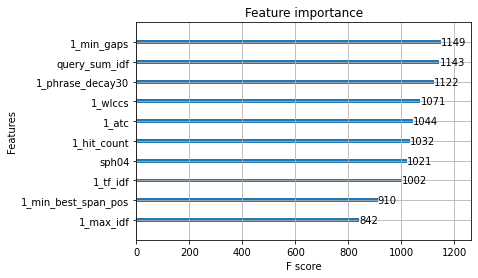

In [115]:
plot_importance(xgb_model, max_num_features=10)

### Spam features

In [748]:
train_use_df = pd.read_csv('train_use_df.csv', sep='\t')
test_use_df = pd.read_csv('test_use_df.csv', sep='\t')

In [854]:
train_use_df = train_use_df.sort_values(by=['query_id', 'doc_id'])
test_use_df = test_use_df.sort_values(by=['query_id', 'doc_id'])

In [722]:
def get_urls(df):
    urls = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        url = url_data_df[url_data_df.doc_id == row.doc_id].url_id.values[0]
        urls.append(url)
    return urls

In [739]:
url_data_df = pd.read_csv('url.data', header=None, sep='\t')
url_data_df.rename(columns={0: "doc_id", 1: "url_id"}, inplace=True)

In [760]:
train_df = pd.read_csv('train_sphinx_df.csv', sep='\t')
test_df = pd.read_csv('test_sphinx_df.csv', sep='\t')

In [740]:
train_urls = get_urls(train_df)
train_df['doc_url'] = train_urls

In [741]:
test_urls = get_urls(test_df)
test_df['doc_url'] = test_urls

In [742]:
train_df.to_csv('train_sphinx_df.csv', index=False, sep='\t')
test_df.to_csv('test_sphinx_df.csv', index=False, sep='\t')

In [155]:
from urllib.parse import urlparse
def get_domain_level(url):
    prefix_www = 'www.'
    if url.find(prefix_www) == 0:
        url = url[len(prefix_www):]
    return len(urlparse(f"http://{url}").netloc.split('.'))

def get_url_len(url):
    return len(list(url.split('/')))

In [765]:
train_use_df = train_use_df.sort_values(by=['query_id', 'doc_id'])
train_df = train_df.sort_values(by=['query_id', 'doc_id'])
test_use_df = test_use_df.sort_values(by=['query_id', 'doc_id'])
test_df = test_df.sort_values(by=['query_id', 'doc_id'])

In [9]:
tqdm.pandas()

In [767]:
train_spam_df = pd.DataFrame()
train_spam_df['query_id'] = train_df['query_id'].values
train_spam_df['doc_id'] = train_df['doc_id'].values
train_spam_df['doc_url'] = train_df['doc_url'].values

In [828]:
train_spam_df['domain_level'] = train_spam_df.progress_apply(lambda row: get_domain_level(row['doc_url']), axis=1)

In [835]:
train_spam_df['url_len'] = train_spam_df.progress_apply(lambda row: get_url_len(row['doc_url']), axis=1)

In [845]:
train_spam_df.to_csv('train_spam_df.csv', index=False, sep='\t')

**test**

In [150]:
test_df = pd.read_csv('test_sphinx_df.csv', sep='\t')

In [151]:
test_use_df.sort_values(by=['query_id', 'doc_id'], inplace=True)
test_df = test_df.sort_values(by=['query_id', 'doc_id'], inplace=True)

In [153]:
test_spam_df = pd.DataFrame()
test_spam_df['query_id'] = test_df['query_id'].values
test_spam_df['doc_id'] = test_df['doc_id'].values
test_spam_df['doc_url'] = test_df['doc_url'].values

In [156]:
test_spam_df['domain_level'] = test_spam_df.progress_apply(lambda row: get_domain_level(row['doc_url']), axis=1)

In [157]:
test_spam_df['url_len'] = test_spam_df.progress_apply(lambda row: get_url_len(row['doc_url']), axis=1)

In [158]:
test_spam_df.to_csv('test_spam_df.csv', index=False, sep='\t')

**Классификатор спама**

In [17]:
from collections import namedtuple
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

In [24]:
spam_train_docs = helpers.load_obj('spam_train_docs')
spam_test_docs = helpers.load_obj('spam_test_docs')

In [25]:
doc_features = spam_train_docs[0].features.keys()
spam_df_columns = ['doc_id', 'target'] + [k for k in doc_features]

In [27]:
spam_train_df = pd.concat([pd.DataFrame([[doc.doc_id, str(int(doc.is_spam))] + [doc.features[k] for k in doc_features]], 
                           columns=spam_df_columns) 
                           for doc in spam_train_docs], ignore_index=True)
spam_train_df.set_index('doc_id',inplace=True)

spam_test_df = pd.concat([pd.DataFrame([[doc.doc_id, str(int(doc.is_spam))] + [doc.features[k] for k in doc_features]], 
                          columns=spam_df_columns) 
                          for doc in spam_test_docs], ignore_index=True)
spam_test_df.set_index('doc_id',inplace=True)

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
spam_texts = pd.concat([spam_train_df['tokenized_text'], spam_test_df['tokenized_text']])

In [30]:
MAX_TFIDF_FEATURES = 50_000
spam_tf_idf_vectorizer = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES, ngram_range = (1, 3))
spam_tf_idf_vectorizer.fit(spam_texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=50000,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [31]:
spam_tf_idf_train = spam_tf_idf_vectorizer.transform(spam_train_df.tokenized_text)
spam_tf_idf_test = spam_tf_idf_vectorizer.transform(spam_test_df.tokenized_text)

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [35]:
X_train, X_test, y_train, y_test = train_test_split(spam_tf_idf_train, spam_train_df['target'], 
                                                    test_size=0.1, random_state=69, stratify=spam_train_df['target'])

In [36]:
model_nb = MultinomialNB().fit(X_train, y_train)

In [37]:
y_pred = model_nb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9303711986255727

In [38]:
model_nb = MultinomialNB().fit(spam_tf_idf_train, spam_train_df['target'])

In [40]:
helpers.save_obj(model_nb, 'spam_model')

In [43]:
helpers.save_obj(spam_tf_idf_vectorizer, 'spam_tf_idf_vectorizer')

**Dataframe с признаками спама**

In [51]:
train_spam_df = pd.read_csv('train_spam_df.csv', sep='\t')
train_use_df = pd.read_csv('train_use_df.csv', sep='\t')

In [8]:
spam_model = helpers.load_obj('spam_model')
spam_tf_idf_vectorizer = helpers.load_obj('spam_tf_idf_vectorizer')

In [52]:
train_use_df['doc_snippet_1024_norm'].fillna('', inplace=True)

In [53]:
train_use_df.sort_values(by=['query_id', 'doc_id'], inplace=True)
train_spam_df.sort_values(by=['query_id', 'doc_id'], inplace=True)

In [54]:
spam_tf_idf_train = spam_tf_idf_vectorizer.transform(train_use_df.doc_snippet_1024_norm)

In [55]:
train_spam_df['proba_spam'] = spam_model.predict_proba(spam_tf_idf_train)[:, 1]

In [26]:
tqdm.pandas()

In [57]:
marks_df = pd.read_csv('train.marks.tsv', sep='\t', header=None)
marks_df.rename(columns={0: "query_id", 1: "doc_id", 2: "mark"}, inplace=True)
train_spam_df['query_id+doc_id'] = train_spam_df.progress_apply(lambda row: str(row['query_id']) + '-' + str(row['doc_id']), axis=1)
marks_df['query_id+doc_id'] = marks_df.progress_apply(lambda row: str(row['query_id']) + '-' + str(row['doc_id']), axis=1)
exist_marks_df = marks_df.loc[marks_df['query_id+doc_id'].isin(train_spam_df['query_id+doc_id'].values)]
exist_marks_df = exist_marks_df.sort_values(by=['query_id', 'doc_id'])

In [60]:
train_spam_df['mark'] = exist_marks_df.mark.values

In [64]:
train_spam_df.sort_values(by=['mark', 'proba_spam'], ascending=False)[:10]

,query_id,doc_id,doc_url,domain_level,url_len,proba_spam,query_id+doc_id,mark
25192,820,163700,battlecarnival.ru/,2,2,0.675125,820-163700,5
28301,905,231956,online.ettu.ru/map/trams,3,3,0.660722,905-231956,5
1706,47,576666,privatbank.ua/udalenniy-banking/privat24/faq-736/,2,5,0.620205,47-576666,5
107340,3506,82757,www.activ.kz/ru/service/number,2,4,0.583333,3506-82757,5
26023,858,253707,gdepapa.ru/,2,2,0.513999,858-253707,5
26027,858,253711,gdepapa.ru/blogs/newpost/,2,4,0.513999,858-253711,5
26633,866,253756,gdeposylka.ru/,2,2,0.411942,866-253756,5
26736,867,253756,gdeposylka.ru/,2,2,0.411942,867-253756,5
28296,905,231950,m.ettu.ru/,3,2,0.398614,905-231950,5
28298,905,231952,mobile.ettu.ru/,3,2,0.398614,905-231952,5


In [62]:
train_spam_df.to_csv('train_spam_df.csv', index=False, sep='\t')

**test**

In [160]:
test_spam_df = pd.read_csv('test_spam_df.csv', sep='\t')
test_use_df = pd.read_csv('test_use_df.csv', sep='\t')

test_spam_df.sort_values(by=['query_id', 'doc_id'], inplace=True)
test_use_df.sort_values(by=['query_id', 'doc_id'], inplace=True)

In [177]:
test_use_df['doc_snippet_1024_norm'].fillna('', inplace=True)

In [178]:
spam_tf_idf_test = spam_tf_idf_vectorizer.transform(test_use_df.doc_snippet_1024_norm)

In [181]:
test_spam_df['proba_spam'] = spam_model.predict_proba(spam_tf_idf_test)[:, 1]

In [182]:
test_spam_df.to_csv('test_spam_df.csv', index=False, sep='\t')

### With USE

In [160]:
tqdm.pandas()

In [240]:
data_df = pd.read_csv('mark_data_df_use_qa.csv', sep='\t')
marks_df = pd.read_csv('train.marks.tsv', sep='\t', header=None)
marks_df.rename(columns={0: "QueryID", 1: "DocID", 2: "Mark"}, inplace=True)

In [241]:
data_df['query_id+doc_id'] = data_df.progress_apply(lambda row: str(row['query_id']) + '-' + str(row['doc_id']), axis=1)

In [242]:
marks_df['query_id+doc_id'] = marks_df.progress_apply(lambda row: str(row['QueryID']) + '-' + str(row['DocID']), axis=1)

In [243]:
exist_marks_df = marks_df.loc[marks_df['query_id+doc_id'].isin(data_df['query_id+doc_id'].values)]

In [244]:
exist_marks_df = exist_marks_df.sort_values(by=['QueryID', 'DocID'])

In [245]:
data_df = data_df.sort_values(by=['query_id', 'doc_id'])

In [246]:
y_train = exist_marks_df['Mark'].values

In [306]:
drop_columns = ['doc_title', 'doc_title_norm', 
                'doc_snippet', 'doc_id', 'query_id', 'query_id+doc_id']

In [271]:
drop_columns = ['doc_title', 'doc_title_norm', 
                'doc_snippet', 'doc_id', 'query_id', 'query_id+doc_id']
drop_columns = drop_columns + list(xgb_fea_imp[xgb_fea_imp.importance < 100]['feature'].values.ravel())

In [209]:
drop_columns = ['doc_title', 'doc_title_norm', 
                'doc_snippet', 'doc_id', 'query_id', 'query_id+doc_id',
                'query_is_number_words',
                '1_is_number_hits',
                '1_lcs',
                '1_has_digit_hits',
                'query_is_latin_words',
                '0_is_number_hits',
                'query_has_digit_words',
                '0_lcs',
                '1_is_latin_hits',
                '0_has_digit_hits',
                '0_exact_order',
                '0_is_latin_hits',
                'document_field_mask',
                '0_exact_field_hit',
                '0_word_count',
                '1_word_count',
                '0_full_field_hit',
                'document_doc_word_count',
                '1_exact_order',
                '0_hit_count']

In [307]:
X_train = data_df.drop(drop_columns, axis=1).to_numpy()

In [308]:
qids_unique = np.unique(train_df['query_id'], return_counts=False)

In [250]:
len(qids_unique)

2111

In [213]:
import xgboost as xgb

In [309]:
grp_val_indices = np.random.choice(qids_unique, 300, replace=False)

In [310]:
t_indices, val_indices = get_t_val_indices(data_df['query_id'].values, grp_val_indices)

In [311]:
X_val = X_train[val_indices]
y_val = y_train[val_indices]
X_t = X_train[t_indices]
y_t = y_train[t_indices]

In [312]:
dt = xgb.DMatrix(data = X_t, label = y_t)
dt.set_group(np.unique(train_df['query_id'].values[t_indices], return_counts=True)[1])
dval = xgb.DMatrix(data = X_val, label = y_val)
dval.set_group(np.unique(train_df['query_id'].values[val_indices], return_counts=True)[1])

In [313]:
params = {'objective': 'rank:ndcg', 'eta': 0.1,
          'max_depth': 10,
          'eval_metric': 'ndcg@5'}

In [314]:
xgb.train(params, dt, num_boost_round=150, evals=[(dval, 'dval')], verbose_eval=True)

[0]	dval-ndcg@5:0.60019
[1]	dval-ndcg@5:0.61547
[2]	dval-ndcg@5:0.61735
[3]	dval-ndcg@5:0.62617
[4]	dval-ndcg@5:0.63311
[5]	dval-ndcg@5:0.63052
[6]	dval-ndcg@5:0.64087
[7]	dval-ndcg@5:0.65632
[8]	dval-ndcg@5:0.65765
[9]	dval-ndcg@5:0.65957
[10]	dval-ndcg@5:0.66065
[11]	dval-ndcg@5:0.66024
[12]	dval-ndcg@5:0.66245
[13]	dval-ndcg@5:0.66197
[14]	dval-ndcg@5:0.66651
[15]	dval-ndcg@5:0.66519
[16]	dval-ndcg@5:0.66662
[17]	dval-ndcg@5:0.66756
[18]	dval-ndcg@5:0.66539
[19]	dval-ndcg@5:0.66794
[20]	dval-ndcg@5:0.67037
[21]	dval-ndcg@5:0.67236
[22]	dval-ndcg@5:0.66893
[23]	dval-ndcg@5:0.66704
[24]	dval-ndcg@5:0.66752
[25]	dval-ndcg@5:0.66617
[26]	dval-ndcg@5:0.66535
[27]	dval-ndcg@5:0.66565
[28]	dval-ndcg@5:0.66810
[29]	dval-ndcg@5:0.67081
[30]	dval-ndcg@5:0.66944
[31]	dval-ndcg@5:0.67200
[32]	dval-ndcg@5:0.67564
[33]	dval-ndcg@5:0.67571
[34]	dval-ndcg@5:0.67563
[35]	dval-ndcg@5:0.67787
[36]	dval-ndcg@5:0.67723
[37]	dval-ndcg@5:0.67541
[38]	dval-ndcg@5:0.67613
[39]	dval-ndcg@5:0.67570
[40]	dval-

In [315]:
X_train = data_df.drop(drop_columns, axis=1)
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtrain.set_group(np.unique(data_df['query_id'], return_counts=True)[1])

In [316]:
xgb_model = xgb.train(params, dtrain, num_boost_round=150)

In [317]:
xgb_fea_imp = pd.DataFrame(list(xgb_model.get_fscore().items()),
                           columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

                     feature  importance
5             sim_use_qa_qt        1952
0                sim_use_qt        1608
4             query_sum_idf        1390
10               1_min_gaps        1359
8                  1_tf_idf        1289
3                   1_wlccs        1257
1          1_phrase_decay30        1194
13                    sph04        1154
20                    1_atc        1124
18              1_hit_count        1087
29      1_min_best_span_pos        1060
6             query_max_idf         958
15                1_max_idf         954
30           1_is_noun_hits         951
24         1_phrase_decay10         920
23            1_min_hit_pos         873
11           document_bm25a         781
36                  0_wlccs         754
32            document_bm15         732
14                1_sum_idf         679
26                0_min_idf         652
25                    0_atc         644
33                 0_tf_idf         582
22                0_max_idf         548

In [318]:
list(xgb_fea_imp[xgb_fea_imp.importance < 100]['feature'].values.ravel())

['1_word_count',
 '0_word_count',
 '1_has_digit_hits',
 'query_has_digit_words',
 '1_is_number_hits',
 '0_lccs',
 '0_lcs',
 'query_is_latin_words',
 'query_is_number_words',
 '1_is_latin_hits',
 '0_is_number_hits',
 '0_has_digit_hits',
 '0_exact_order',
 'document_field_mask',
 '0_exact_field_hit',
 '0_is_latin_hits',
 '0_full_field_hit']

### With click models

In [65]:
train_df = pd.read_csv('train_sphinx_df.csv', sep='\t')
train_use_df = pd.read_csv('train_use_df.csv', sep='\t')
train_cm_df = pd.read_csv('train_cm_df.csv', sep='\t')
train_spam_df = pd.read_csv('train_spam_df.csv', sep='\t')
marks_df = pd.read_csv('train.marks.tsv', sep='\t', header=None)
marks_df.rename(columns={0: "query_id", 1: "doc_id", 2: "mark"}, inplace=True)

In [66]:
train_df['query_id+doc_id'] = train_df.progress_apply(lambda row: str(row['query_id']) + '-' + str(row['doc_id']), axis=1)
marks_df['query_id+doc_id'] = marks_df.progress_apply(lambda row: str(row['query_id']) + '-' + str(row['doc_id']), axis=1)

In [68]:
exist_marks_df = marks_df.loc[marks_df['query_id+doc_id'].isin(train_df['query_id+doc_id'].values)]
exist_marks_df = exist_marks_df.sort_values(by=['query_id', 'doc_id'])
train_df.sort_values(by=['query_id', 'doc_id'], inplace=True)
train_use_df.sort_values(by=['query_id', 'doc_id'], inplace=True)
train_cm_df.sort_values(by=['query_id', 'doc_id'], inplace=True)
train_spam_df.sort_values(by=['query_id', 'doc_id'], inplace=True)
y_train = exist_marks_df['mark'].values

In [70]:
drop_columns = ['doc_id', 'query_id', 'query_id+doc_id', 'doc_url']

In [92]:
train_df['sim_use_qa_qss_1024_un'] = train_use_df['sim_use_qa_qss_1024_un'].values
train_df['sim_use_qa_qss_512_un'] = train_use_df['sim_use_qa_qss_512_un'].values
train_df['sim_use_qa_qts_1024_un'] = train_use_df['sim_use_qa_qts_1024_un'].values
train_df['sim_use_qa_qts_512_un'] = train_use_df['sim_use_qa_qts_512_un'].values
train_df['sim_use_qa_qtt'] = train_use_df['sim_use_qa_qtt'].values
train_df['sim_use_qa_qtt_un'] = train_use_df['sim_use_qa_qtt_un'].values
train_df['sim_use_qs_1024_un'] = train_use_df['sim_use_qs_1024_un'].values
train_df['sim_use_qs_512_un'] = train_use_df['sim_use_qs_512_un'].values
train_df['sim_use_qt'] = train_use_df['sim_use_qt'].values
train_df['sim_use_qt_un'] = train_use_df['sim_use_qt_un'].values

train_df['cm_rel'] = train_cm_df['cm_rel'].values
train_df['dctr_rel'] = train_cm_df['dctr_rel'].values
train_df['gctr_rel'] = train_cm_df['gctr_rel'].values
train_df['sdbn_rel'] = train_cm_df['sdbn_rel'].values
train_df['dcm_rel'] = train_cm_df['dcm_rel'].values
train_df['ubm_rel'] = train_cm_df['ubm_rel'].values
train_df['dbn_rel'] = train_cm_df['dbn_rel'].values

train_df['domain_level'] = train_spam_df['domain_level'].values
train_df['url_len'] = train_spam_df['url_len'].values
train_df['proba_spam'] = train_spam_df['proba_spam'].values

In [190]:
train_df.to_csv('train_df.csv', index=False, sep='\t')